# Bayes Supply Chain

Impl of [blog](https://twiecki.io/blog/2019/01/14/supply_chain/) for pymc5

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pymc as pm
from scipy import stats
import arviz as az
from tqdm import tqdm

In [3]:
SUPPLIER_YIELD = np.array([.9, .5, .8]) # unknown
SUPPLIER_YIELD_SD = np.array([.1, .2, .2]) # unknown
PRICES = [220.0, 100.0, 120.0] # known
MAX_ORDER_SIZE = [100, 80, 100] # known

In [4]:
N_OBS = [30, 20, 2]
np.random.seed(100)
data = []
for supplier_yield, supplier_yield_sd, n_obs in zip(SUPPLIER_YIELD, SUPPLIER_YIELD_SD, N_OBS):
  data.append(pm.draw(pm.Beta.dist(mu=supplier_yield, sigma=supplier_yield_sd, shape=n_obs)))
data

[array([0.9287271 , 0.68999857, 0.93452508, 0.94214318, 0.98640991,
        0.6024365 , 0.97763865, 0.98521242, 0.87931336, 0.84364264,
        0.98122882, 0.83714702, 0.97650798, 0.95231683, 0.91528453,
        0.932849  , 0.87236834, 0.77782646, 0.92297574, 0.77887328,
        0.89336648, 0.97810555, 0.78930913, 0.84435056, 0.87590356,
        0.99738265, 0.99051409, 0.89518909, 0.97235351, 0.98112732]),
 array([0.67014093, 0.32295859, 0.6803901 , 0.38395872, 0.46122336,
        0.58920128, 0.8301753 , 0.60677722, 0.56313447, 0.53181431,
        0.70256276, 0.61086793, 0.57251174, 0.88174938, 0.53855146,
        0.25706947, 0.63673929, 0.56841933, 0.70782388, 0.20161468]),
 array([0.97874476, 0.93260403])]

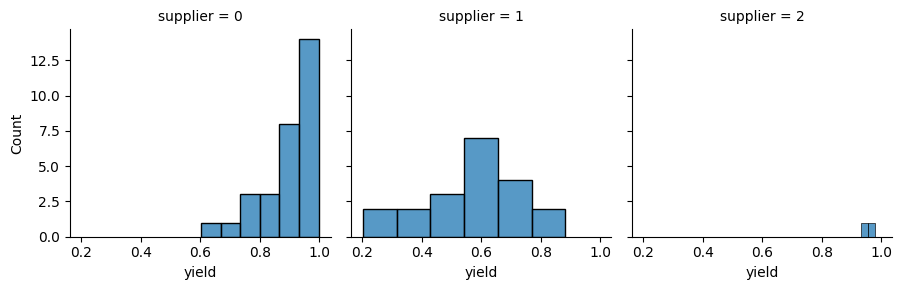

In [22]:
data_df = pd.DataFrame(data).T
data_tidy = data_df.unstack().to_frame('yield')
data_tidy.index = data_tidy.index.set_names(['supplier', 'obs'])
g = sns.FacetGrid(data=data_tidy.reset_index().dropna(), col='supplier')
g.map(sns.histplot, 'yield', kde=False)

In [7]:
SALES_PRICE = 500
HOLDING_COST = 100

@np.vectorize
def loss(in_stock, demand, buy_price, sales_price=SALES_PRICE, holding_cost=HOLDING_COST):
    # How much do we earn per launch
    margin = sales_price - buy_price
    # Do we have more in stock than demanded?
    if in_stock > demand:
        total_profit = demand * margin
        # everything left over after demand was met goes into holding
        total_holding_cost = (in_stock - demand) * holding_cost
        reward = total_profit - total_holding_cost
    else:
        # Can only sell what we have in stock, no storage required
        reward = in_stock * margin

    # Usually we minimize, so invert
    return -reward

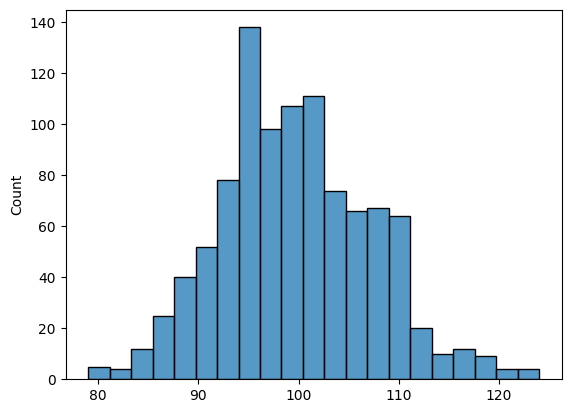

In [8]:
demand_samples = stats.poisson(60, 40).rvs(1000)
sns.histplot(demand_samples)

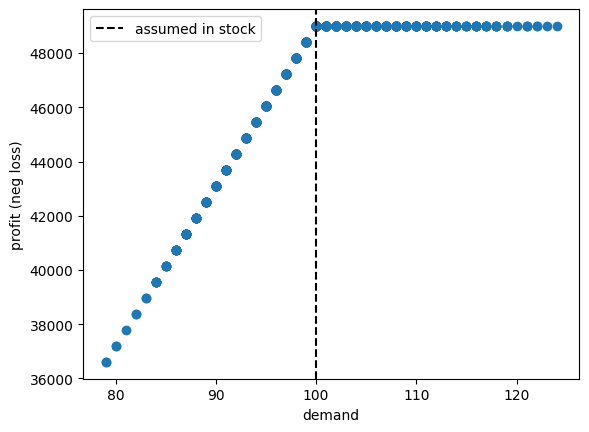

In [9]:
plt.scatter(demand_samples, -loss(in_stock=100, demand=demand_samples, buy_price=10))
plt.xlabel('demand'); plt.ylabel('profit (neg loss)'); plt.axvline(100, c='k', ls='--', label='assumed in stock');
plt.legend()

In [10]:
with pm.Model() as model:
    # Priors on alpha and beta parameters for each supplier
    α = pm.HalfNormal('α', sigma=10., shape=3)
    β = pm.HalfNormal('β', sigma=10., shape=3)

    # Different likelihood for every supplier because we have different
    # number of data points
    for i, d in enumerate(data):
        pm.Beta(f'supplier_yield_obs_{i}',
            alpha=α[i], beta=β[i],
            observed=d)

    trace = pm.sample()
    # trace = pm.sample(2000, tune=1000, initvals={'supplier_yield_obs_0': np.array([0.]), 'supplier_yield_obs_1': np.array([0.])})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β]


c:\Users\timashan\AppData\Local\Programs\Python\Python311\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 54 seconds.


<Axes: >

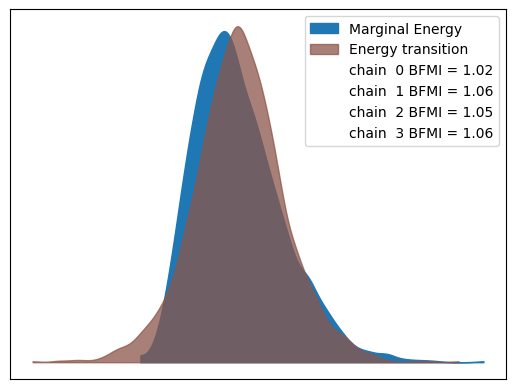

In [11]:
az.plot_energy(trace)

In [12]:
with model:
    post_pred = pm.sample_posterior_predictive(trace, predictions=True)

Sampling: [supplier_yield_obs_0, supplier_yield_obs_1, supplier_yield_obs_2]


c:\Users\timashan\AppData\Local\Programs\Python\Python311\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

In [30]:
trace.posterior.to_dataframe()

α         β
chain draw α_dim_0 β_dim_0                    
0     0    0       0        7.269859  0.683229
                   1        7.269859  4.156348
                   2        7.269859  1.376693
           1       0        4.767714  0.683229
                   1        4.767714  4.156348
...                              ...       ...
3     999  1       1        4.813324  4.221818
                   2        4.813324  0.548727
           2       0        5.719834  1.128144
                   1        5.719834  4.221818
                   2        5.719834  0.548727

[36000 rows x 2 columns]

In [23]:
supplier_yield_post_pred = pd.DataFrame({k: v[:, 1] for k, v in post_pred.items()})


ValueError: Unsupported key-type <class 'tuple'>